In [39]:
from csidh import CSIDHDLL
PATH = "/home/xjaros2/Documents/git/csidh-setup/csidh-target/src/"
csidhdll = CSIDHDLL(src_path=PATH)


def isogeny_in_distance(public, i):
    csidhdll.public = csidhdll.to_projective(public)
    private = [0, 0, 0]
    
    private[i] = -1
    csidhdll.private = private
    positive_isogeny_skipped =  csidhdll.from_projective(csidhdll.action())

    private[i] = 1
    csidhdll.private = private
    negative_isogeny_skipped = csidhdll.from_projective(csidhdll.action())
    return [positive_isogeny_skipped, negative_isogeny_skipped]

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/xjaros2/Documents/git/csidh-setup/csidh-target/src/build
[100%] Built target csidh


In [2]:
# isogeny_offsets = [
#     (5,474252), # The if statement in both branches before isogenies cost 8 cycles  
#     (7,574920),
#     (5,1109332),
#     (3,1638652),
#     (5,1799384),
#     (7,1952772),
#     (3,2377220)
# ]
isogeny_offsets = [
    (5, 118555, 139478),
    (7, 161541, 175472),
    (5, 312859, 333855), 
    (3, 462833, 478086),
    (5, 508058, 529109),
    (7, 551170, 565075),
    (3, 672017, 687331),
    #(3, 717500, 738726)
]



In [62]:
from copy import deepcopy
import json
import re
import time
import pandas as pd
import seaborn as sns
from csidh.search import Unit

import os
os.chdir("/home/xjaros2/Documents/git/csidh-setup/csidh-target/scripts/")



def read_cachefile(filename):
    with open(filename, "r") as f:
        measurements = json.load(f)
    measurements = measurements["measurements"]
    result = []
    for i in range(len(measurements)):
        unit = Unit(repr=measurements[i]["unit"], parser="new", num_glitches=2)
        measurements[i].update(unit.__dict__())
        unit.measurements = measurements[i]["measurements"]
        unit.responses = measurements[i]["responses"]        
        del measurements[i]["index"]
        measurements[i]["unit"] = unit
        result.append(measurements[i])
    return result

def read_cachefiles_to_dataframe(cachefiles):
    df = None
    for filename in cachefiles:
        result = pd.DataFrame(read_cachefile(filename))
        if df is None:
            df = result
        else:
            df = pd.concat([df, result], ignore_index=True, sort=False)
    return df

In [63]:
husky = [
    "./husky-clock-ISOGENY-DOUBLE-SKIP.json"
]

df = read_cachefiles_to_dataframe(husky)
# df = df[df["type"] == "JUSTRIGHT"].reset_index()
df

,unit,responses,measurements,ext_offset,offset,width,repeat,type,fitness,offset_fine,width_fine
0,"(ext_offset=[287531, 317784], offset=32.0, wid...","[199, 199, 199, 199, 199]","[JUSTRIGHT, JUSTRIGHT, JUSTRIGHT, JUSTRIGHT, J...","[287531, 317784]",32.0,398.0,13,JUSTRIGHT,10.0,None,None
1,"(ext_offset=[287531, 317784], offset=390.0, wi...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[287531, 317784]",390.0,93.0,2,NORMAL,2.0,None,None
2,"(ext_offset=[287531, 317784], offset=390.0, wi...","[199, 199, 199, 199]","[RESET, JUSTRIGHT, JUSTRIGHT, JUSTRIGHT, JUSTR...","[287531, 317784]",390.0,93.0,13,CHANGING,9.3,None,None
3,"(ext_offset=[500457, 157768], offset=4023.0, w...","[344, 344, 344, 344, 344]","[JUSTRIGHT, JUSTRIGHT, JUSTRIGHT, JUSTRIGHT, J...","[500457, 157768]",4023.0,606.0,18,JUSTRIGHT,10.0,None,None
4,"(ext_offset=[500457, 157768], offset=4021.0, w...",[],"[RESET, RESET, RESET, RESET, RESET]","[500457, 157768]",4021.0,585.0,14,RESET,5.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...
52694,"(ext_offset=[5433, 579137], offset=3990.0, wid...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[5433, 579137]",3990.0,266.0,8,NORMAL,2.0,None,None
52695,"(ext_offset=[5433, 579137], offset=3990.0, wid...",[],"[RESET, RESET, RESET, RESET, RESET]","[5433, 579137]",3990.0,266.0,18,RESET,5.0,None,None
52696,"(ext_offset=[1680, 20220], offset=127.0, width...","[199, 199, 199, 199]","[JUSTRIGHT, JUSTRIGHT, RESET, JUSTRIGHT, JUSTR...","[1680, 20220]",127.0,378.0,16,CHANGING,9.3,None,None
52697,"(ext_offset=[1680, 20220], offset=4303.0, widt...","[199, 199, 199, 199, 199]","[JUSTRIGHT, JUSTRIGHT, JUSTRIGHT, JUSTRIGHT, J...","[1680, 20220]",4303.0,593.0,13,JUSTRIGHT,10.0,None,None


In [64]:
DOUBLE_ISOGENY_SKIP_PUBLICS = {}
EXPECTED_PUBLIC = 0


l =  {
    0:3,
    1:5,
    2:7
}

for i in range(3):
    neighbours = isogeny_in_distance(EXPECTED_PUBLIC, i)
    for j, x in enumerate(neighbours):
        prime_1 = l[i]
        direction_1 = -1 if j==0 else 1
        for k in range(3):
            neighbourss = isogeny_in_distance(x, k)
            for n, y in enumerate(neighbourss):
                prime_2 = l[k]
                direction_2 = -1 if n == 0 else 1 
                DOUBLE_ISOGENY_SKIP_PUBLICS.setdefault(y, [])
                DOUBLE_ISOGENY_SKIP_PUBLICS[y].append((prime_1 * direction_1, prime_2 * direction_2))


DOUBLE_ISOGENY_SKIP_PUBLICS

{9: [(-3, -3)],
 0: [(-3, 3), (3, -3), (-5, 5), (5, -5), (-7, 7), (7, -7)],
 29: [(-3, -5), (-5, -3)],
 124: [(-3, 5), (5, -3)],
 275: [(-3, -7), (-7, -3)],
 404: [(-3, 7), (7, -3)],
 410: [(3, 3)],
 295: [(3, -5), (-5, 3)],
 390: [(3, 5), (5, 3)],
 15: [(3, -7), (-7, 3)],
 144: [(3, 7), (7, 3)],
 368: [(-5, -5)],
 379: [(-5, -7), (-7, -5), (7, 7)],
 228: [(-5, 7), (7, -5)],
 51: [(5, 5)],
 191: [(5, -7), (-7, 5)],
 40: [(5, 7), (-7, -7), (7, 5)]}

In [65]:
potential_skips = df.iloc[[i for i, x in enumerate(df["responses"]) if any(y in x for y in DOUBLE_ISOGENY_SKIP_PUBLICS) or x == []]]
#potential_skips.response = potential_skips.responses.apply(lambda x: x[0])
potential_skips

,unit,responses,measurements,ext_offset,offset,width,repeat,type,fitness,offset_fine,width_fine
1,"(ext_offset=[287531, 317784], offset=390.0, wi...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[287531, 317784]",390.0,93.0,2,NORMAL,2.0,None,None
4,"(ext_offset=[500457, 157768], offset=4021.0, w...",[],"[RESET, RESET, RESET, RESET, RESET]","[500457, 157768]",4021.0,585.0,14,RESET,5.0,None,None
5,"(ext_offset=[500457, 157768], offset=4021.0, w...",[],"[RESET, RESET, RESET, RESET, RESET]","[500457, 157768]",4021.0,585.0,18,RESET,5.0,None,None
8,"(ext_offset=[503132, 93841], offset=4327.0, wi...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[503132, 93841]",4327.0,601.0,9,NORMAL,2.0,None,None
15,"(ext_offset=[1061, 73914], offset=241.0, width...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[1061, 73914]",241.0,215.0,6,NORMAL,2.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...
52687,"(ext_offset=[10855, 71001], offset=226.0, widt...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[10855, 71001]",226.0,231.0,10,NORMAL,2.0,None,None
52689,"(ext_offset=[489915, 44036], offset=3894.0, wi...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[489915, 44036]",3894.0,702.0,7,NORMAL,2.0,None,None
52694,"(ext_offset=[5433, 579137], offset=3990.0, wid...",[],"[NORMAL, NORMAL, NORMAL, NORMAL, NORMAL]","[5433, 579137]",3990.0,266.0,8,NORMAL,2.0,None,None
52695,"(ext_offset=[5433, 579137], offset=3990.0, wid...",[],"[RESET, RESET, RESET, RESET, RESET]","[5433, 579137]",3990.0,266.0,18,RESET,5.0,None,None


In [66]:
value_counts = {}
for value in DOUBLE_ISOGENY_SKIP_PUBLICS:
    for response in potential_skips.responses:
        if value in response:
            value_counts.setdefault(value, 0)
            value_counts[value] += 1
        elif value == EXPECTED_PUBLIC and response == []:
            value_counts.setdefault(value, 0)
            value_counts[value] += 1
value_counts       

{9: 8,
 0: 20971,
 29: 127,
 124: 193,
 275: 20,
 404: 70,
 410: 39,
 295: 262,
 390: 86,
 15: 68,
 144: 243,
 368: 113,
 379: 503,
 228: 187,
 51: 19,
 191: 180,
 40: 28}

In [67]:
raw_nodes = {EXPECTED_PUBLIC:(EXPECTED_PUBLIC,0)}
raw_edges = []


for i in range(3):
    d1_nodes = isogeny_in_distance(EXPECTED_PUBLIC, i)
    for d1_node in d1_nodes:
        raw_nodes[d1_node] = (d1_node, 0)
        raw_edges.append((EXPECTED_PUBLIC, d1_node, l[i]))
        for j in range(3):
            d2_nodes = isogeny_in_distance(d1_node, j)
            for d2_node in d2_nodes:
                raw_nodes[d2_node] = (d2_node, value_counts[d2_node])
                raw_edges.append((d1_node, d2_node, l[j]))


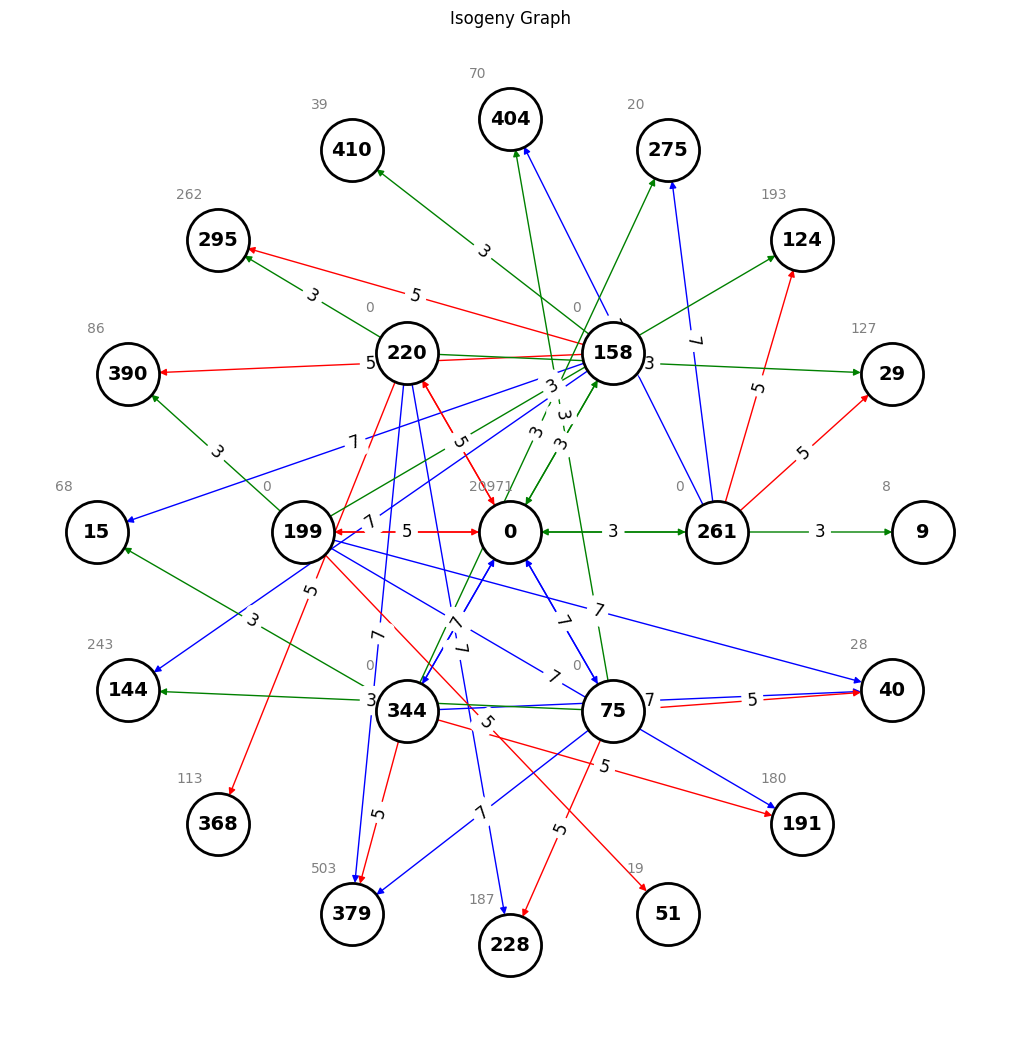

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from collections import deque, defaultdict


# === Create Graph ===
G = nx.DiGraph()
for node, (main, small) in raw_nodes.items():
    G.add_node(node, main=main, small=small)
for u, v, w in raw_edges:
    G.add_edge(u, v, weight=w)

# === BFS Layers from Root ===
root = EXPECTED_PUBLIC
layers = defaultdict(list)
visited = set()
queue = deque([(root, 0)])
while queue:
    node, depth = queue.popleft()
    if node in visited:
        continue
    visited.add(node)
    layers[depth].append(node)
    for neighbor in G.successors(node):
        if neighbor not in visited:
            queue.append((neighbor, depth + 1))

# === Positioning in Concentric Circles ===
pos = {}
radius_step = 2.5
for depth, nodes in layers.items():
    radius = depth * radius_step
    angle_step = 2 * math.pi / max(len(nodes), 1)
    for i, node in enumerate(nodes):
        angle = i * angle_step
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        pos[node] = (x, y)

# === Edge Colors by Label ===
edge_colors = []
for u, v in G.edges():
    w = G[u][v]['weight']
    if w == 3:
        edge_colors.append("green")
    elif w == 5:
        edge_colors.append("red")
    elif w == 7:
        edge_colors.append("blue")
    else:
        edge_colors.append("gray")

# === Draw the Graph ===
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_color="white", edgecolors="black",
        edge_color=edge_colors, node_size=2000, linewidths=2)

# Node Labels (Main + Small)
for node in G.nodes():
    x, y = pos[node]
    plt.text(x, y, str(G.nodes[node]['main']), fontsize=14, fontweight="bold",
             ha='center', va='center', color="black")
    plt.text(x - 0.5, y + 0.5, str(G.nodes[node]['small']), fontsize=10, color="gray")

# Edge Labels
edge_labels = {(u, v): str(G[u][v]['weight']) for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.axis('off')
plt.title("Isogeny Graph")
plt.savefig("isogeny-graph.pdf")

In [69]:
isogeny_in_distance(isogeny_in_distance(0, 0)[0], 0)[0]

9

In [70]:
isogeny_in_distance(isogeny_in_distance(0, 1)[1], 1)[1]

51

In [71]:
isogeny_in_distance(isogeny_in_distance(0, 2)[0], 2)[0]

40

In [120]:
stats = {
    "Total" : len(df),
    "Normal": len(df[df.type == "NORMAL"]),
    "Reset" : len(df[df.type == "RESET"]),
    "Changing": len(df[df.type == "CHANGING"]),
    "Justright": len(df[df.type == "JUSTRIGHT"]),
}

def shorten(pair):
    fst = f"(+){pair[0]}" if pair[0] > 0 else f"(-){-pair[0]}"
    snd = f"(+){pair[1]}" if pair[1] > 0 else f"(-){-pair[1]}"
    return f"{fst}{snd}"


distance2 = 0
for key, degrees in DOUBLE_ISOGENY_SKIP_PUBLICS.items():
    label = list(map(shorten, set(map(tuple,map(sorted, degrees)))))
    count = len(df[df.responses.apply(lambda x: key in x)])
    distance2 += count
    stats[';'.join(label) + f"-{key}"] = count


distance1 = 0
for key in isogeny_in_distance(0, 1) + isogeny_in_distance(0, 2) + isogeny_in_distance(0, 0):
    count = len(df[df.responses.apply(lambda x: key in x)])
    distance1 += count

garbage = 0
DISTANCE12 = isogeny_in_distance(0, 1) + isogeny_in_distance(0, 2) + isogeny_in_distance(0, 0) + list(DOUBLE_ISOGENY_SKIP_PUBLICS.keys())
print(DISTANCE12)
df[~df.type.isin(["NORMAL", "RESET"]) & df.responses & df.responses.apply(lambda x: not any([key in x for key in DISTANCE12]))]
867/52699

[220, 199, 344, 75, 261, 158, 9, 0, 29, 124, 275, 404, 410, 295, 390, 15, 144, 368, 379, 228, 51, 191, 40]


0.016451925083967436

In [94]:
stats

{'Total': 52699,
 'Normal': 5893,
 'Reset': 11877,
 'Changing': 16842,
 'Justright': 18087,
 '(-)3(-)3-9': 8,
 '(-)3(+)3;(-)7(+)7;(-)5(+)5-0': 0,
 '(-)5(-)3-29': 127,
 '(-)3(+)5-124': 193,
 '(-)7(-)3-275': 20,
 '(-)3(+)7-404': 70,
 '(+)3(+)3-410': 39,
 '(-)5(+)3-295': 262,
 '(+)3(+)5-390': 86,
 '(-)7(+)3-15': 68,
 '(+)3(+)7-144': 243,
 '(-)5(-)5-368': 113,
 '(-)7(-)5;(+)7(+)7-379': 503,
 '(-)5(+)7-228': 187,
 '(+)5(+)5-51': 19,
 '(-)7(+)5-191': 180,
 '(+)5(+)7;(-)7(-)7-40': 28}

In [85]:
percentages = {}
for key in stats:
    percentages[key] =100 *stats[key] / stats["Total"]
percentages

{'Total': 100.0,
 'Normal': 11.18237537714188,
 'Reset': 22.537429552742935,
 'Changing': 31.958860699444013,
 'Justright': 34.32133437067117,
 '(-)3(-)3-9': 0.015180553710696598,
 '(-)3(+)3;(-)7(+)7;(-)5(+)5-0': 0.0,
 '(-)5(-)3-29': 0.2409912901573085,
 '(-)3(+)5-124': 0.3662308582705554,
 '(-)7(-)3-275': 0.037951384276741496,
 '(-)3(+)7-404': 0.13282984496859523,
 '(+)3(+)3-410': 0.07400519933964592,
 '(-)5(+)3-295': 0.4971631340253136,
 '(+)3(+)5-390': 0.16319095238998843,
 '(-)7(+)3-15': 0.12903470654092108,
 '(+)3(+)7-144': 0.46110931896240914,
 '(-)5(-)5-368': 0.21442532116358945,
 '(-)7(-)5;(+)7(+)7-379': 0.9544773145600486,
 '(-)5(+)7-228': 0.35484544298753296,
 '(+)5(+)5-51': 0.03605381506290442,
 '(-)7(+)5-191': 0.34156245849067346,
 '(+)5(+)7;(-)7(-)7-40': 0.053131937987438094}

In [92]:
csidhdll.public = csidhdll.to_projective(0)
private = [0, 0, -2]
csidhdll.private = private
positive_isogeny_skipped =  csidhdll.from_projective(csidhdll.action())
positive_isogeny_skipped

40

In [1]:
sum([0.015180553710696598,
0.0,
0.2409912901573085,
 0.3662308582705554,
 0.037951384276741496,
 0.13282984496859523,
0.07400519933964592,
0.4971631340253136,
0.16319095238998843,
 0.12903470654092108,
0.46110931896240914,
0.21442532116358945,
0.9544773145600486,
0.35484544298753296,
0.03605381506290442,
0.34156245849067346,
0.053131937987438094])

4.072183532894363